# Make your own behaviour kernel
In this example, we will show how to turn on/off existing behaviour kernels, and how you can make your own behaviour kernel and use it in `plasticparcels`.

In [1]:
# Library imports
from datetime import datetime, timedelta
import os
os.chdir('../../')
# Parcels and PlasticParcels imports
import plasticparcels as pp

# Plotting imports
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

## Load settings
We will first load in some model settings and define simulation settings in order to show how to add/remove behaviour kernels. For this simulation, we will release the particles at midnight on January 1st 2019. The particle trajectories will be 30 days long, saving the their position every 12 hours. We also set the advection timestep to 20 minutes. We will also download the necessary release location files (if they are not already downloaded). To speed things up, we will focus our simulation to be in the Mediterranean Sea, so we include indices in our ocean model to help speed up the file IO.

In [4]:
# Load the model settings
settings_file = 'docs/examples/example_make_your_own_kernel.json'
settings = pp.utils.load_settings(settings_file)

In [5]:
# Create the simulation settings
settings['simulation'] = {
    'start_date': datetime.strptime('2019-01-01-00:00:00', '%Y-%m-%d-%H:%M:%S'), # Start date of simulation
    'runtime': timedelta(days=30),             # Runtime of simulation, use negative if releasing particles backwards in time
    'dt_write': timedelta(hours=12),             # Timestep of output
    'dt_timestep': timedelta(minutes=20),       # Timestep of advection
    }

# Overwrite some settings
settings['use_3D'] = True
settings['use_biofouling'] = False
settings['use_stokes'] = True
settings['use_wind'] = True


In [6]:
# Create the particle release settings
settings['release'] = {
    'initialisation_type': 'coastal',
    'country': 'Croatia',
}

In [5]:
# Create the plastic type settings
settings['plastictype'] = {
    'wind_coefficient' : 0.01, # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1030., # Plastic particle density (kg/m^3)
}

In [6]:
settings['ocean']['indices'] = {'lon':range(3300, 4000), 'lat':range(1850, 2400)}#, 'depth':range(0,2)}

In [7]:
# Download the mask and release data
settings = pp.utils.download_plasticparcels_dataset('NEMO0083', settings, 'input_data')

In [8]:
# Create the fieldset
fieldset = pp.constructors.create_fieldset(settings)

In [9]:
# Create the particleset
pset = pp.constructors.create_particleset_from_map(fieldset, settings)

In [10]:
# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)

In [11]:
# Define the runtime, the timestepping, and the output frequency of the simulation from the settings
runtime = settings['simulation']['runtime']
dt_timestep = settings['simulation']['dt_timestep']
dt_write = settings['simulation']['dt_write']

In [12]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_Italy_coast.zarr', pset, settings=settings, outputdt=dt_write)

In [13]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt_timestep, output_file=pfile)

INFO: Output files are stored in example_Italy_coast.zarr.
100%|██████████| 2592000.0/2592000.0 [00:35<00:00, 73750.52it/s]


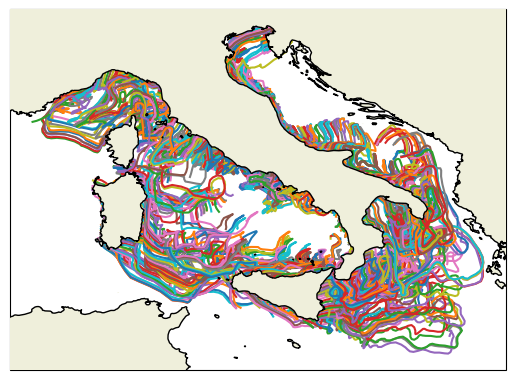

In [14]:
# Plot the trajectories
ds = xr.open_zarr('example_Italy_coast.zarr')

ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=19)
ax.coastlines(zorder=20)
ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree())

plt.show()